# Multiclass segmentation: PyTorch version
We want to optimize the mean Jaccard index of the non-void classes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn

In [4]:
import lovasz_losses as L

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from tqdm.notebook import tqdm

In [11]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')
from demo_utils import pil, pil_grid, dummy_triangles

In [12]:
from collections import OrderedDict as OD

In [13]:
CUDA = True

In [14]:
def cuda(x):
    if CUDA:
        return x.cuda()
    else:
        return x

## Multiclass case: batch of 5 random images with classes [0, 1, 2] and void (255)
We assume that we want to optimize the Jaccard index of all non-void classes 0, 1 and 2.

### Labels

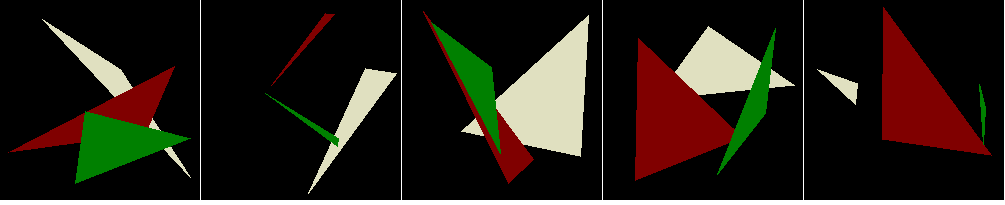

In [15]:
np.random.seed(18)
C = 3
B = 5
H = 200
labels_ = [dummy_triangles(H, [0, 255, 1, 2]) for b in range(B)]
labels = torch.stack([torch.from_numpy(a) for a in map(np.array, labels_)]).long()
pil_grid(labels_, 5, margin=1)

In [16]:
labels.size()

torch.Size([5, 200, 200])

### Features

In [17]:
np.random.seed(57)
B, H, W = labels.size()
labels_ = labels.clone()
labels_[labels_ == 255] = labels_[labels_ == 255].random_(C) # random feats for void
labels_1hot = torch.zeros(B, C, H, W)
labels_1hot.scatter_(1, labels_.unsqueeze(1), 1);

In [18]:
labels_1hot.size()

torch.Size([5, 3, 200, 200])

In [19]:
feats = labels_1hot.clone().float()
feats += feats.new(feats.size()).normal_(0, 2) # additive gaussian noise

In [20]:
feats.size()

torch.Size([5, 3, 200, 200])

In [21]:
labels = cuda(labels)
feats = Variable(cuda(feats))

## Model

### definition

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, padding=1)
        
    def forward(self, x):
        return x + self.conv(x)

In [23]:
m = Model()
init_state_dict = OD([(n, p.clone()) for (n, p) in m.state_dict().items()])

In [24]:
init_state_dict

OrderedDict([('conv.weight',
              tensor([[[[-0.1827,  0.1089,  0.0031],
                        [ 0.1667,  0.0896,  0.1898],
                        [-0.0290, -0.1444, -0.1152]],
              
                       [[ 0.1690, -0.0205, -0.1161],
                        [ 0.1277,  0.1549,  0.1600],
                        [-0.1589,  0.0942, -0.1117]],
              
                       [[ 0.0550, -0.0747, -0.1241],
                        [ 0.1374,  0.1787,  0.0973],
                        [ 0.1487,  0.1395,  0.0675]]],
              
              
                      [[[-0.0382,  0.1068,  0.0671],
                        [-0.1343, -0.1389,  0.1301],
                        [ 0.1554,  0.0925, -0.0457]],
              
                       [[ 0.1151, -0.0740,  0.0172],
                        [-0.0689, -0.0147, -0.0092],
                        [-0.1258,  0.0655, -0.0784]],
              
                       [[-0.1635, -0.0718,  0.0227],
                        [-0

In [25]:
m = cuda(m)

### Initial prediction

In [26]:
_, preds = m(feats).data.max(1)
print("Initial batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Initial mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Initial batch-IoUs: [43.76429061 13.59340333  6.50360594]
Initial mIoU: 21.287099961043076


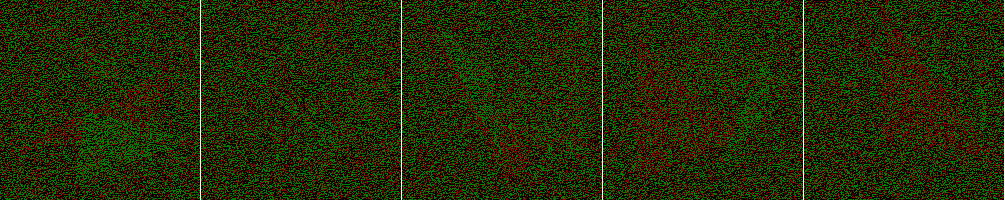

In [27]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász-Softmax training

In [37]:
m.load_state_dict(init_state_dict)

optimizer = Adam(m.parameters(), lr=0.005)

loss_plot = []
iou_plot = []

for iter in tqdm(range(1000)):
    optimizer.zero_grad()
    out = m(feats)
    out = F.softmax(out, dim=1)
    print(out.size(), out.min(), out.max())
    print(labels.size())
    break
    loss = L.lovasz_softmax(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    _, preds = out.data.max(1)
    loss_plot.append(loss.item())
    iou_plot.append(L.iou_binary(preds, labels, ignore=255, per_image=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 200, 200]) tensor(7.3494e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([5, 200, 200])


Text(0.5, 0, 'iteration')

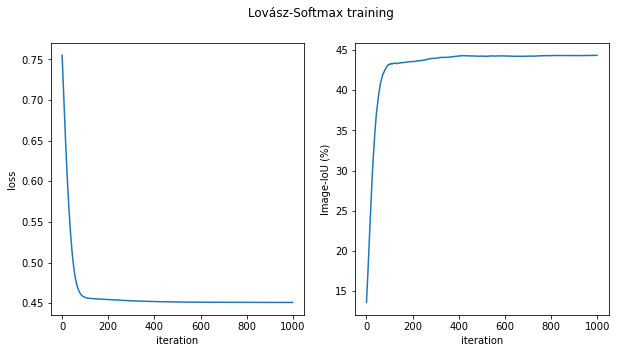

In [30]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász-Softmax training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [31]:
_, preds = m(feats).data.max(1)
print("Final batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Final mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Final batch-IoUs: [87.31403808 44.34882387 30.86366881]
Final mIoU: 54.175510252328685


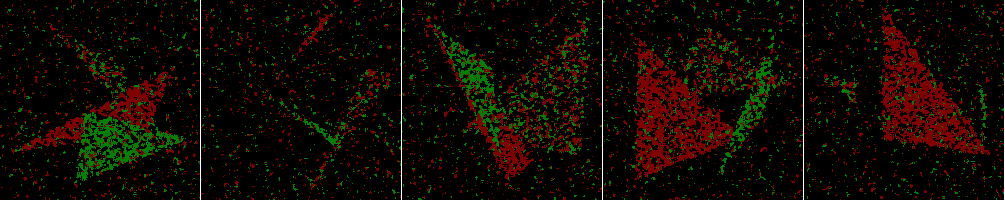

In [32]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Cross-entropy training

In [33]:
m.load_state_dict(init_state_dict)

optimizer = Adam(m.parameters(), lr=0.005)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(1000)):
    optimizer.zero_grad()
    out = m(feats)
    loss = L.xloss(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    _, preds = out.data.max(1)
    loss_plot_x.append(loss.item())
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, 'iteration')

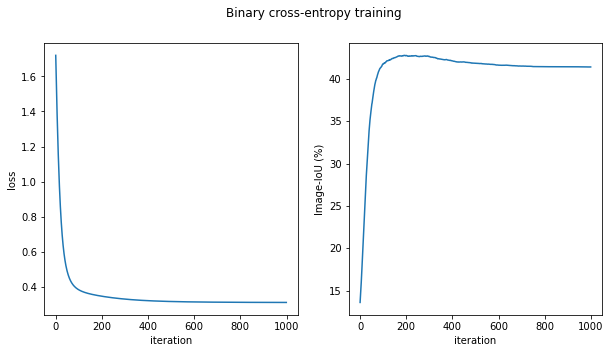

In [34]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Binary cross-entropy training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [35]:
_, preds = m(feats).data.max(1)
print("Final batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Final mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Final batch-IoUs: [88.53528691 41.41739343 26.85851319]
Final mIoU: 52.270397844107755


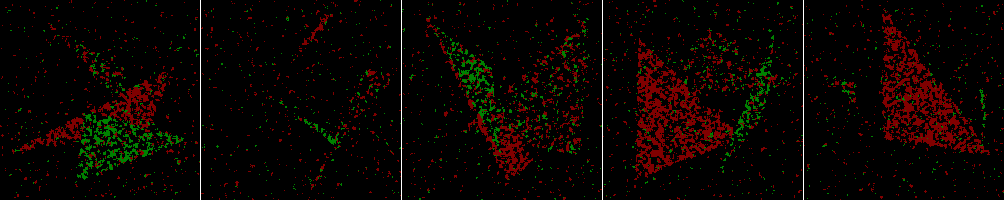

In [36]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)